In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
os.environ["TRANSFORMERS_CACHE"]="/workspace/cache"
os.environ["HF_DATASETS_CACHE"]="/workspace/cache"
os.environ["WANDB_DISABLED"] = "true"


In [8]:
import datasets
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

import os
import requests
from tqdm import tqdm
import pickle 
from PIL import Image
from glob import glob
import numpy as np

from ollama import Client
client = Client(host='http://10.204.100.191:11434')

/root/anaconda3/envs/llava/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
with open('coyo_filtered_1k.pkl', 'rb') as file:   
    # Call load method to deserialze 
    coyo_dataset = pickle.load(file) 

In [5]:
sea_vqa_dataset = load_dataset('wit543/sea-vqa')

In [6]:
coyo_images = glob('coyo_downloaded_images/*')
sea_vqa_images = glob('sea_vqa_downloaded_images/*')

In [9]:
model = SentenceTransformer("sentence-transformers/clip-ViT-B-32")

/root/anaconda3/envs/llava/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [24]:
coyo_images_embed = []
coyo_images_filtered = []
coyo_caption = []
coyo_path = []
for img in tqdm(coyo_images):
    try:
        img_opened = Image.open(img)
        coyo_images_embed.append(model.encode(img_opened))
        coyo_images_filtered.append(img_opened)
        country_code, index = img.split('/')[-1].replace('.jpg','').split('_')
        coyo_caption.append(coyo_dataset[country_code][int(index)][0])
        coyo_path.append(img)
    except:
        pass

    
sea_vqa_images_filtered = []
sea_vqa_images_embed = []
sea_vqa_caption = []
sea_vqa_path = []
for img in tqdm(sea_vqa_images):
    try:
        img_opened = Image.open(img)
        sea_vqa_images_embed.append(model.encode(img_opened))
        sea_vqa_images_filtered.append(img_opened)
        country_code, index = img.split('/')[-1].replace('.jpg','').split('_')
        sea_vqa_caption.append(sea_vqa_dataset[country_code]['question'][int(index)])
        sea_vqa_path.append(img)
    except:
        pass

assert len(coyo_images_embed) == len(coyo_images_filtered) == len(coyo_caption)
assert len(sea_vqa_images_filtered) == len(sea_vqa_images_embed) == len(sea_vqa_caption)

100%|██████████████████████████████████████████████████████████████████████| 1999/1999 [01:19<00:00, 25.30it/s]


# Coyo

In [11]:
scores = model.similarity(sea_vqa_images_embed, coyo_images_embed)

/root/anaconda3/envs/llava/lib/python3.10/site-packages/sentence_transformers/util.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  a = torch.tensor(a)


In [38]:
scores.shape

torch.Size([1999, 559])

In [41]:
top_k=5
cands = []
cands_cap = []
cands_path = []
for idx in range(1,len(sea_vqa_images_embed)):
    sorted_index = np.argsort(np.array(scores[idx]))[::-1]
    image = sea_vqa_images_filtered[idx]
    caption = sea_vqa_caption[idx]
    print(f"Query:{image}")
    for rank, cand_idx in enumerate(sorted_index[:top_k]):
        print(f"Candidate:{coyo_images_filtered[cand_idx]} score:{scores[idx][cand_idx]}")
        cands.append(coyo_images_filtered[cand_idx])
        cands_cap.append(coyo_caption[cand_idx])
        cands_path.append(coyo_path[cand_idx])
    print("*"*100)
    break

Query:<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x685 at 0x7FDCA06F4AF0>
Candidate:<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=850x478 at 0x7FDCA016BD00> score:0.7518916130065918
Candidate:<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=215x215 at 0x7FDCA0A05180> score:0.7318423986434937
Candidate:<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1177x876 at 0x7FDCA09BF250> score:0.7072498202323914
Candidate:<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=215x215 at 0x7FDCA09BD8A0> score:0.6964403390884399
Candidate:<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x640 at 0x7FDCA09BD450> score:0.6439152956008911
****************************************************************************************************


In [47]:
top_k=5
cands = []
cands_cap = []
cands_path = []
non_related_img = []
non_related_path = []
non_related_cap = []
for idx in range(1,len(coyo_images_filtered)):
    sorted_index = np.argsort(np.array(scores[idx]))[::-1]
    image = sea_vqa_images_filtered[idx]
    caption = sea_vqa_caption[idx]
    print(f"Query:{image}")
    for rank, cand_idx in enumerate(sorted_index[:top_k]):
        print(f"Candidate:{coyo_images_filtered[cand_idx]} score:{scores[idx][cand_idx]}")
        cands.append(coyo_images_filtered[cand_idx])
        cands_cap.append(coyo_caption[cand_idx])
        cands_path.append(coyo_path[cand_idx])
    
    sorted_index = np.argsort(np.array(scores[idx]))
    for rank, cand_idx in enumerate(sorted_index[:top_k]):
        non_related_img.append(coyo_images_filtered[cand_idx])
        non_related_path.append(coyo_path[cand_idx])
        non_related_cap.append(coyo_caption[cand_idx])
    print("*"*100)
    break

Query:<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x685 at 0x7FDCA06F4AF0>
Candidate:<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=850x478 at 0x7FDCA016BD00> score:0.7518916130065918
Candidate:<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=215x215 at 0x7FDCA0A05180> score:0.7318423986434937
Candidate:<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1177x876 at 0x7FDCA09BF250> score:0.7072498202323914
Candidate:<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=215x215 at 0x7FDCA09BD8A0> score:0.6964403390884399
Candidate:<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x640 at 0x7FDCA09BD450> score:0.6439152956008911
****************************************************************************************************


# original image from sea-vqa

In [13]:
caption

'Which gender appears to predominate among the performers?'

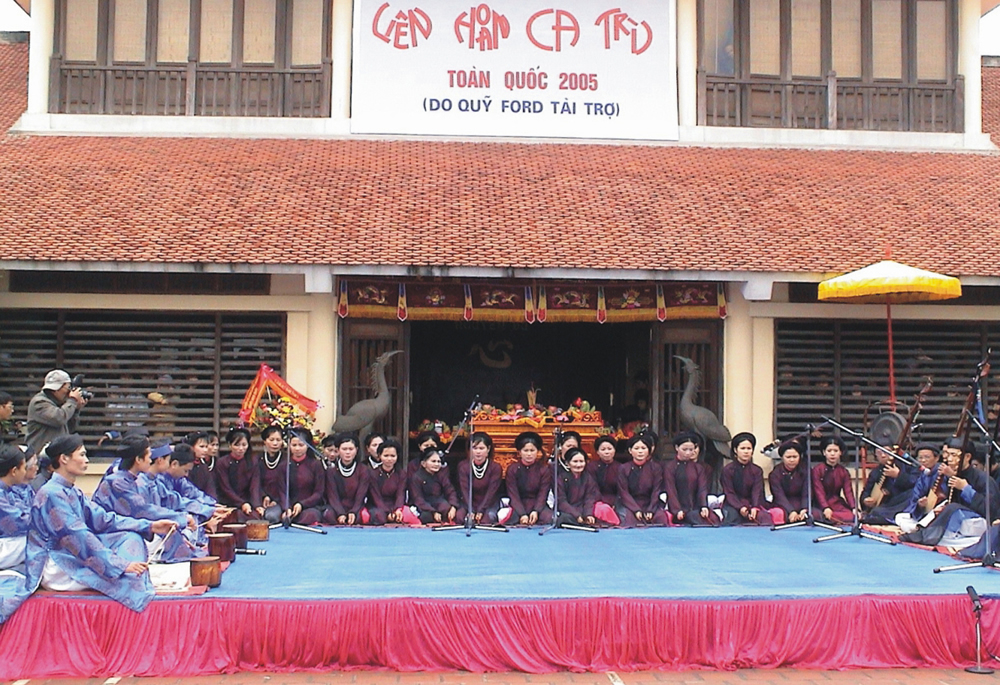

In [14]:
image

### Candidate

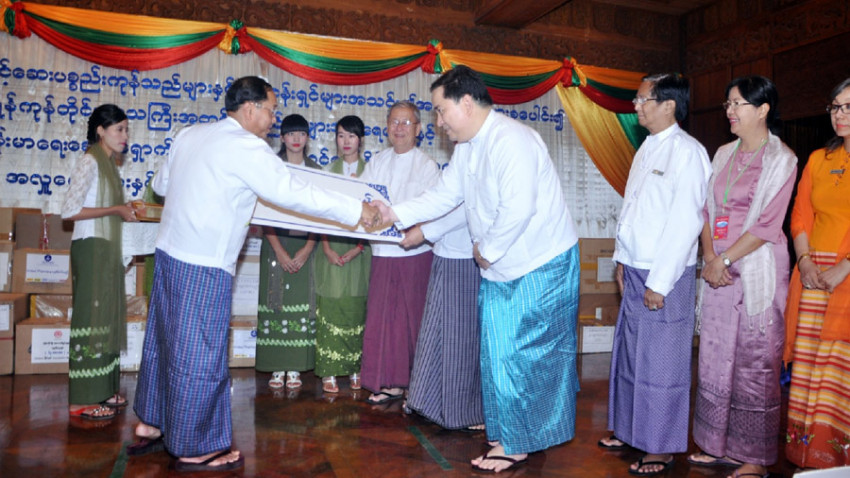

In [26]:
cands[0]

In [27]:
cands_cap[1]

'Senior General Min Aung Hlaing meets officers, other ranks, families and trainee officers and other ranks of local advanced training depot of Tangyan Station and officers, other ranks and families of the station'

In [28]:
from ollama import Client
client = Client(host='http://10.204.100.191:11434')

In [59]:
res = client.chat(
    model="llava:7b-v1.6",
    messages=[
        {
            'role': 'user',
            'content': f'Is the image and caption is happened or related to Southeast Asian or not in terms of cultural, people, cloth, and character that appear in the image or caption? The answer should start with Yes or No. Caption:{non_related_cap[-1]}',
            'images': [cands_path[1]]
        }
    ]
)
res['message']['content']

' Yes '

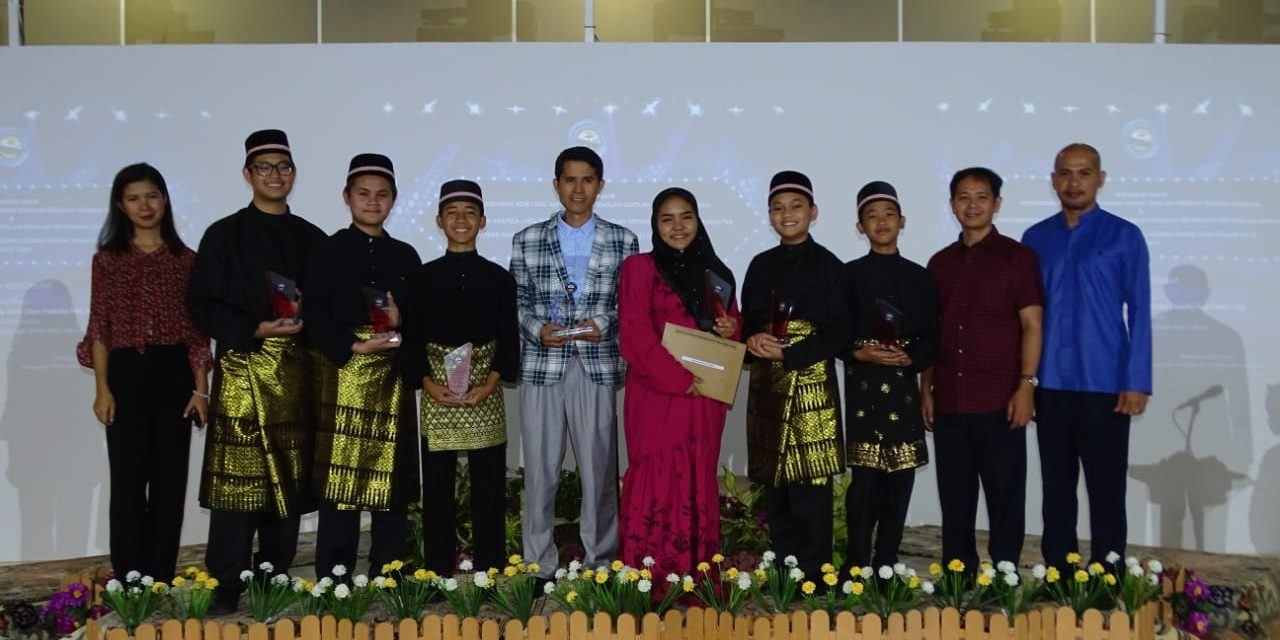

In [19]:
cands[-1]

In [58]:
res = client.chat(
    model="llava:7b-v1.6",
    messages=[
        {
            'role': 'user',
            'content': f'Is the image and caption is happened or related to Southeast Asian or not in terms of cultural, people, cloth, and character that appear in the image or caption? The answer should start with Yes or No. Caption:{non_related_cap[-1]}',
            'images': [cands_path[-1]]
        }
    ]
)
res['message']['content']

' No, the image does not depict Southeast Asian culture or people. It shows a group of individuals who appear to be at an event or ceremony, possibly related to a religious or cultural occasion. They are wearing traditional clothing and posing for a photo in front of a stage with decorations. The presence of a podium suggests that speeches or presentations might have taken place. However, the image does not provide enough specific information about their location or the exact nature of the event. '

# non-related images

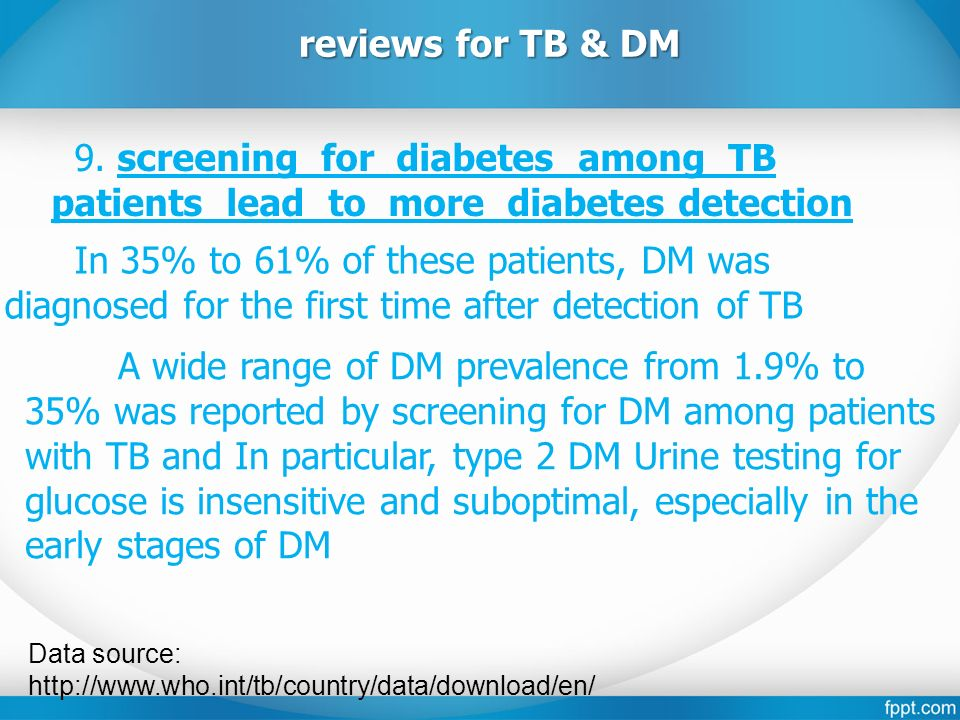

In [48]:
non_related_img[0]

In [49]:
non_related_cap[0]

'Data source: reviews for TB & DM 9.'

In [52]:
res = client.chat(
    model="llava:7b-v1.6",
    messages=[
        {
            'role': 'user',
            'content': f'Is the image and caption is happened or related to Southeast Asian or not in terms of cultural, people, and etc? The answer should start with Yes or No. Caption:{non_related_cap[-1]}',
            'images': [non_related_path[-1]]
        }
    ]
)
res['message']['content']

' No, the image and caption are not related to Southeast Asian culture. The image is of a drawing of a person with thought bubbles above them, and there\'s text that says "Freakin\' Out / All Over Me - Graham Coxon," which is an album or single by an artist named Graham Coxon. '